In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together"""
    return a * b

In [5]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [6]:
ai_message = llm_with_tools.invoke("What is 3 plus 5?")

In [7]:
ai_message

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUicSWzfMkXYZC9oEBaIg7OhbEp5s', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a306d628-59a9-4589-bca1-7968e33eb852-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_KBct9CGf1jwHThi3TNVeSj04', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 17, 'total_tokens': 92, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_KBct9CGf1jwHThi3TNVeSj04')]}

In [16]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [10]:
def agent(state: MessagesState):
    message = state['messages']
    response = llm_with_tools.invoke(message)
    return {'messages': [response]}

In [11]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal['tools', 'end']:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return 'end'
        

In [17]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent', 
    should_continue,
    {
        'tools': 'tools',
        'end': END
    }
)
graph_builder.add_edge('tools', 'agent')

In [19]:
graph = graph_builder.compile()

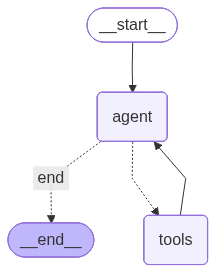

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
from langchain_core.messages import HumanMessage


messages = [HumanMessage(content="What is 2 + 3? What is 2 * 2?")]

In [23]:
graph.invoke({'messages': messages})

{'messages': [HumanMessage(content='What is 2 + 3? What is 2 * 2?', additional_kwargs={}, response_metadata={}, id='b6e87b32-2d14-48bf-ad1f-329c541afbbe'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 83, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUilU7jqjyHxmBCLouy5YuiqHSBC2', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--970b5859-73b6-46cc-a9d5-5920be08cb82-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_hfhl8jsf5kLYGcrExRb2Ih9W', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2, 'b': 2}, 'id': 'call_Cmk8vHhVZ4uyUKmu

In [ ]:
for chunk in graph.stream({'messages': messages}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()


<generator object Pregel.stream at 0x1174ae6f0>